## Refresh data

The end goal is to estimate when a person of a given age would get their first vaccination. 
To achieve this, ideally we would want a time-series dataset of what percentage of the population has received a single dose, coupled with population and demographic statistics, as locally as possible.
This dataset, as far as I can tell, does not exist, so we must create what we can and approximate the rest.
BC's COVID-19 dashboard supplies the number of single-shot people at the Health Region level, which is the most local information available.
However, it does not supply time-series data for this, just the cumulative total and delta against the last report.
BC's official APIs seem to be almost completely unaware of vaccination data, but luckily a project run by students and faculty at the University of Saskatoon has been tracking this.
Their API is excellent, but their data is only granular to the provincial level.
In lieu of the ideal dataset, we can make estimates. 
Assuming that province-wide vaccination trends map somewhat closely to the Vancouver Coastal Health Region's data, we can normalize the USask data with the number pulled from BC's ArcGIS internal API.

In [43]:
from requests import get

shots = get("https://api.covid19tracker.ca/reports/province/bc", params={"stat":"vaccinations", "after":"2021-02-01"}).json()['data']
doubleshots = get("https://api.covid19tracker.ca/reports/province/bc", params={"stat":"vaccinated", "after":"2021-02-01"}).json()['data']

arcgis_parameters = {
    "f": "json",
    "where": "(HA_Name<>'BC') AND (HA_Name='Vancouver Coastal')",
    "outStatistics": '[{"statisticType":"sum","onStatisticField":"One_Dose_Admin","outStatisticFieldName":"One_Dose_Admin"}]'
}

vch_single_shot = get("https://services1.arcgis.com/xeMpV7tU1t4KD3Ei/arcgis/rest/services/BC_COVID19Dashboard_Vaccine_Counts/FeatureServer/0/query", params=arcgis_parameters).json()['features'][0]['attributes']['One_Dose_Admin']
# chain of object & list indexing delves through the deeply nested JSON response to the single integer that we desire

## Processing, deserialization, and cleaning

In [44]:
from datetime import date
import numpy as np

def cleanser(pair):
    """
    maps 'None' values to zero, reduces shot & doubleshot down to the desired data point, and converts date strings into datetime dates
    in effect, this is a secondary deserialization step
    """
    (shots_day, doubleshot_day) = pair # unpack tuple
    return [
        date.fromisoformat(shots_day['date']), 
        shots_day['total_vaccinations'] - (doubleshot_day['total_vaccinated'] if doubleshot_day['total_vaccinated'] != None else 0)
    ]

singleshots = map(cleanser, zip(shots, doubleshots)) # number of people who have had at least one shot
singleshots = np.transpose(tuple(singleshots))
singleshots[1] *= vch_single_shot/singleshots[-1][-1] # approximate the vaccinated population of VCH
singleshots[1] /= 994826/100 # total population of VCH over 20

In [47]:
ordinal_dates = list(map(date.toordinal, singleshots[0]))
trendline = np.polyfit(ordinal_dates, singleshots[1].astype(float), 2)

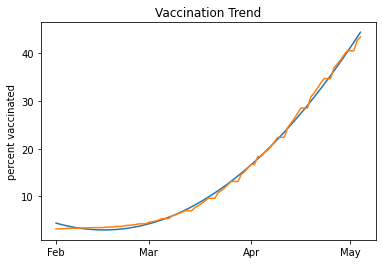

In [46]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()

ax.set_ylabel("percent vaccinated")
ax.set_title("Vaccination Trend")

locator = mdates.AutoDateLocator(minticks=3, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.plot(singleshots[0], np.polyval(trendline, ordinal_dates))
ax.plot(singleshots[0], singleshots[1])
